<hr>
<center><h1>Prédiction du nombre de lettres dans un mot</h1></center>
 <hr>
 <p>
 Dans ce notebook nous allons prédire le nombre de lettres sur une image représentant un mot. On teste 3 modèles:

<ol>
<li>  Réseau de neurones dense </li>
<li>   Réseau de neurones convolutif </li>
<li> Réseau LeNet </li>
</ol>

 </p>

In [ ]:
# Pour corriger erreur UNIMPLEMENTED: DNN library is not found
# pendant l'entraînement CNN
# ! Redémarrer ensuite l'environnement d'exécution
#!pip install tensorflow==2.8
#

<h2> Importation des fichiers </h2>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir database
! mkdir database/ascii
! tar xzf drive/MyDrive/ocr/database/ascii.tgz -C database/ascii

! mkdir database/words
! tar xzf drive/MyDrive/ocr/database/words.tgz -C database/words
#! mkdir database/lines
#! tar xzf drive/MyDrive/ocr/database/lines.tgz -C database/lines


! cp drive/MyDrive/ocr/src/importation.py importation.py


<h2> Importation des modules nécessaires</h2>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import metrics
from sklearn.model_selection import train_test_split

import itertools

import cv2


<h2>Importation des données dans un dataframe</h2>

In [ ]:
from importation import Importation
imp = Importation("database")
words = imp.get_words(drop_err_seg=True)
words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96454 entries, 0 to 96453
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   word_id          96454 non-null  object
 1   result_w_seg     96454 non-null  object
 2   greylevel        96454 non-null  object
 3   x                96454 non-null  object
 4   y                96454 non-null  object
 5   w                96454 non-null  object
 6   h                96454 non-null  object
 7   grammatical_tag  96454 non-null  object
 8   label            96454 non-null  object
 9   file             96454 non-null  object
 10  form_id          96454 non-null  object
 11  writer_id        96454 non-null  object
 12  word_size        96454 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 10.3+ MB


<h2>Préparation des données</h2>
<p>On se limite aux mots ayant moins de 11 lettres
</p>

In [ ]:
n_lettres_max=11
df = words[words.word_size<=n_lettres_max][['file', 'word_size']]
print("Nombre d'enregistrements ", df.shape[0])

print("Répartition des mots par nombre de lettres :\n")
df_freq = pd.DataFrame(df.groupby('word_size').count())
df_freq["freq"] = 100*df.groupby('word_size').count()/df.shape[0]
#print(df.groupby('word_size').count())
print(df_freq)

Nombre d'enregistrements  95285
Répartition des mots par nombre de lettres :

            file       freq
word_size                  
1          14172  14.873275
2          14800  15.532350
3          18659  19.582306
4          13869  14.555282
5           9546  10.018366
6           7008   7.354778
7           6312   6.624338
8           4425   4.643963
9           3256   3.417117
10          2099   2.202865
11          1139   1.195361


<p>On redimensionne les images à <strike>75% de la taille moyenne</strike> 128x32
</p>

In [ ]:
dim_fixed = True
if  not dim_fixed:
  img_size = imp.get_images_size(df["file"])
  img_width = img_size.apply(lambda x : x[0])
  img_height = img_size.apply(lambda x : x[1])
  width_average = int(img_width.mean())
  height_average = int(img_height.mean())
  print(f"largeur moyenne : {width_average} pixels")
  print(f"hauteur moyenne : {height_average} pixels")

  # On redimensionne les images à 75% de leur taille originale
  width = int(width_average * 0.75)
  height = int(height_average * 0.75)
else:
  width = 128
  height = 32
print('Nouvelle dimension :')
print(f"largeur  : {width} pixels")
print(f"hauteur  : {height} pixels")

Nouvelle dimension :
largeur  : 128 pixels
hauteur  : 32 pixels


In [ ]:
X = []
Y = []

dim = (width, height)
for file, word_size in zip(df["file"],df["word_size"]):
    image = cv2.resize(cv2.imread(file, cv2.IMREAD_GRAYSCALE),
                  dim, cv2.IMREAD_GRAYSCALE)
    X.append(np.array(image))
    Y.append(str(word_size))

# Normalise input data to range [0,1]
X = np.array(X)
X = X.astype('float32')
shape = list(X.shape)
shape.append(1)
X = X.reshape(shape)
X /= 255.0

print(X.shape)

(95285, 32, 128, 1)


In [ ]:
Y = to_categorical(Y)
# pas de mots à 0 lettres:
#Y = Y[:, 1:]
# Train and testing split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,test_size=0.3,
                                                    random_state=42  )
num_classes = y_train.shape[1]
print(num_classes)

12


In [ ]:
#del words, df, img_height, img_width, img_size
if 'words' in locals(): del words
if 'df' in locals(): del df
if 'X' in locals(): del X
if 'Y' in locals(): del Y

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def train_model(model, X_train, y_train):
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  training_history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 16, batch_size = 64, verbose = 1)
  train_loss = training_history.history["loss"]
  val_loss = training_history.history["val_loss"]
  train_acc = training_history.history["accuracy"]
  val_acc = training_history.history["val_accuracy"]

  plt.figure(figsize = (20, 8))

  plt.subplot(121)
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.title('Model loss per epoch')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='right')

  plt.subplot(122)
  plt.plot(train_acc)
  plt.plot(val_acc)
  plt.title('Model accuracy per epoch')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='right')

  plt.show()

  return training_history

def predict_model(model, X_test, y_test, model_name):
  y_pred = model.predict(X_test)
  accuracy = metrics.accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm = metrics.confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  print(f"Accuracy model {model_name} : ", accuracy)
  plot_confusion_matrix(cm, range(1,12), cmap=plt.get_cmap('Oranges'))
  return y_pred, accuracy, cm


<h3>Dense Model</h3>

In [ ]:
if 'model' in locals(): del model

inputs_dense=Input(shape = (height, width,1), name = "Input")
dense_0 = Flatten()
#dense_1 = Dense(units = 512, input_dim = height*width, kernel_initializer ='normal', activation ='relu')     
dense_1 = Dense(units = 512, kernel_initializer ='normal', activation ='relu')    
dense_2 = Dense(units = 256, kernel_initializer ='normal', activation ='relu')     
output = Dense(units = num_classes, kernel_initializer ='normal', activation ='softmax')

x=dense_0(inputs_dense)
x=dense_1(x)
x = dense_2(x)
outputs_dense=output(x)
model = Model(inputs = inputs_dense, outputs = outputs_dense)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 128, 1)]      0         
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               2097664   
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 12)                3084      
                                                                 
Total params: 2,232,076
Trainable params: 2,232,076
Non-trainable params: 0
_________________________________________________________________


Epoch 1/16
834/834 [==============================] - 14s 12ms/step - loss: 1.8460 - accuracy: 0.3392 - val_loss: 1.6729 - val_accuracy: 0.3790
Epoch 2/16
834/834 [==============================] - 4s 5ms/step - loss: 1.5978 - accuracy: 0.4046 - val_loss: 1.5576 - val_accuracy: 0.4133
Epoch 3/16
834/834 [==============================] - 6s 7ms/step - loss: 1.5312 - accuracy: 0.4219 - val_loss: 1.4618 - val_accuracy: 0.4440
Epoch 4/16
834/834 [==============================] - 6s 7ms/step - loss: 1.4694 - accuracy: 0.4423 - val_loss: 1.5423 - val_accuracy: 0.4174
Epoch 5/16
834/834 [==============================] - 5s 6ms/step - loss: 1.4266 - accuracy: 0.4572 - val_loss: 1.4283 - val_accuracy: 0.4641
Epoch 6/16
834/834 [==============================] - 8s 10ms/step - loss: 1.4152 - accuracy: 0.4610 - val_loss: 1.3455 - val_accuracy: 0.4850
Epoch 7/16
834/834 [==============================] - 7s 8ms/step - loss: 1.3600 - accuracy: 0.4809 - val_loss: 1.3609 - val_accuracy: 0.4775
Epo

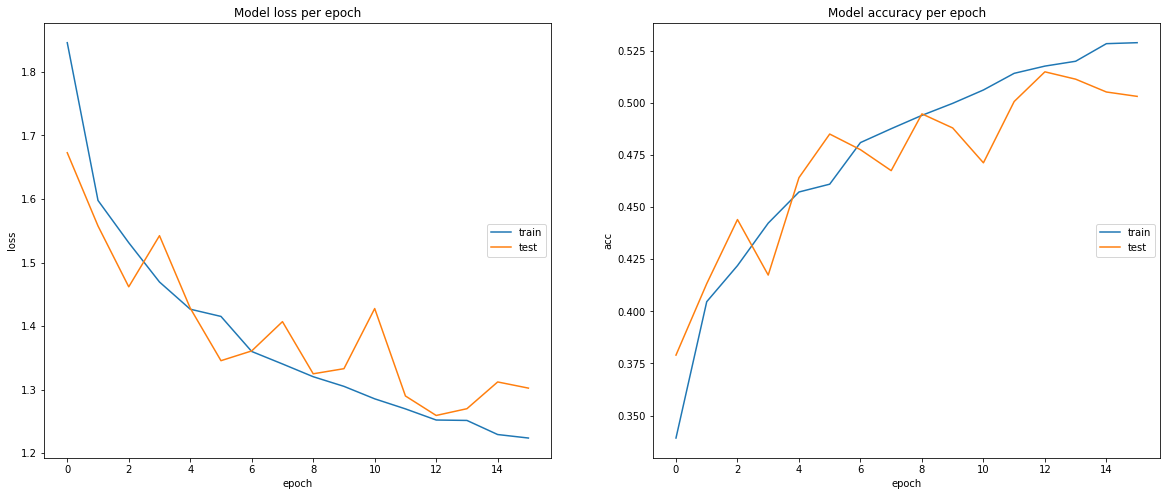

In [ ]:
training_history_dense = train_model(model, X_train, y_train)


Accuracy model Dense Model :  0.4991254460225285


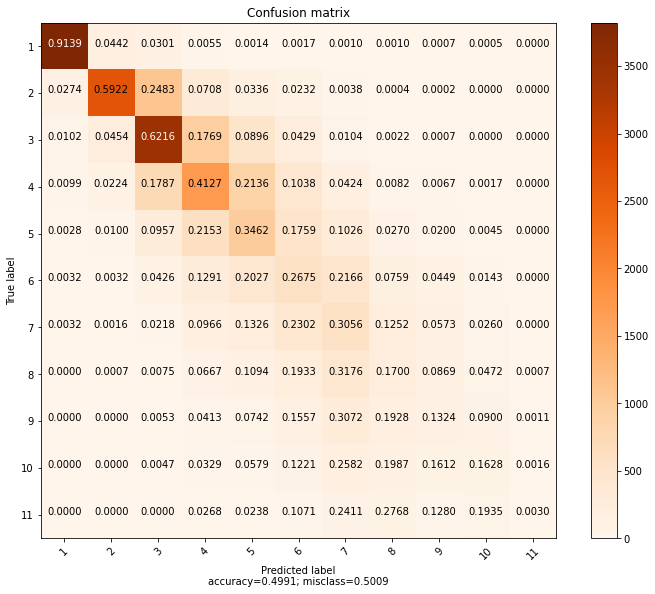

In [ ]:
y_pred_dense, accuracy_dense, cm_dense = predict_model(model, X_test, y_test, 'Dense Model')
del y_pred_dense

<h3>CNN</h3>

In [ ]:
if 'model' in locals(): del model

inputs_cnn=Input(shape = (height, width,1), name = "Input")
cnn_1 = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu')
#cnn_1 = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', input_shape = (height, width,1), activation = 'relu')
cnn_2 = MaxPooling2D(pool_size = (2, 2))
cnn_3 = Dropout(rate = 0.2)
cnn_4 = Flatten()
cnn_5 = Dense(units = 128, activation = 'relu')
cnn_6 = Dense(units = num_classes, activation='softmax')

x=cnn_1(inputs_cnn)
x=cnn_2(x)
x=cnn_3(x)
x=cnn_4(x)
x=cnn_5(x)
outputs_cnn=cnn_6(x)

model = Model(inputs = inputs_cnn, outputs = outputs_cnn, name='CNN')
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 124, 32)       832       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 62, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 14, 62, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 27776)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               3555456   
                                                               

Epoch 1/16
834/834 [==============================] - 16s 18ms/step - loss: 1.2716 - accuracy: 0.5143 - val_loss: 1.0914 - val_accuracy: 0.5624
Epoch 2/16
834/834 [==============================] - 9s 11ms/step - loss: 0.9837 - accuracy: 0.6076 - val_loss: 1.0222 - val_accuracy: 0.5888
Epoch 3/16
834/834 [==============================] - 11s 13ms/step - loss: 0.9189 - accuracy: 0.6354 - val_loss: 0.9992 - val_accuracy: 0.6021
Epoch 4/16
834/834 [==============================] - 10s 12ms/step - loss: 0.8673 - accuracy: 0.6537 - val_loss: 0.9270 - val_accuracy: 0.6247
Epoch 5/16
834/834 [==============================] - 11s 13ms/step - loss: 0.8235 - accuracy: 0.6760 - val_loss: 0.9693 - val_accuracy: 0.6187
Epoch 6/16
834/834 [==============================] - 10s 11ms/step - loss: 0.7706 - accuracy: 0.6957 - val_loss: 0.9332 - val_accuracy: 0.6361
Epoch 7/16
834/834 [==============================] - 9s 10ms/step - loss: 0.7272 - accuracy: 0.7128 - val_loss: 0.9519 - val_accuracy: 0

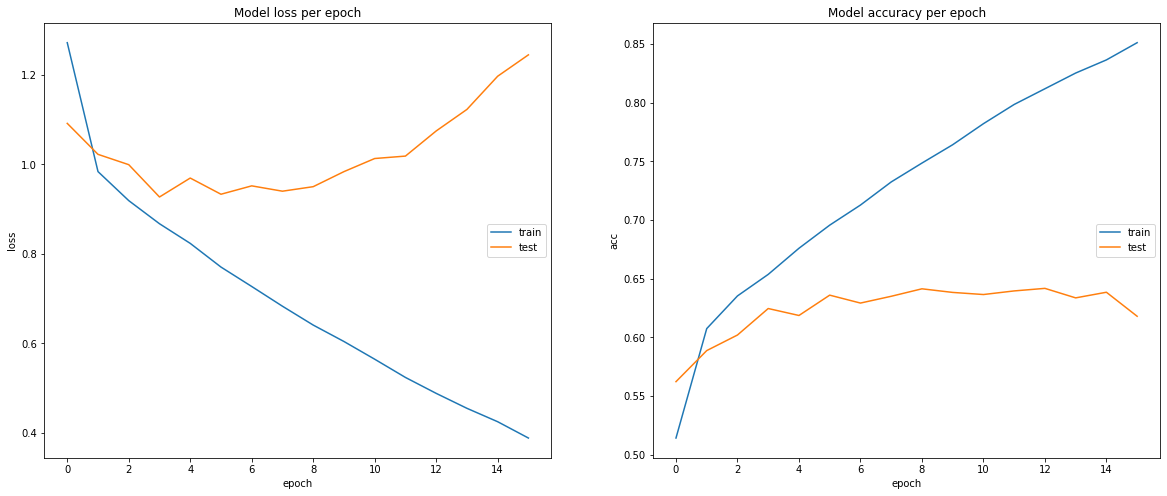

In [ ]:
training_history_cnn = train_model(model, X_train, y_train)



Accuracy model CNN Model :  0.6201287343454838


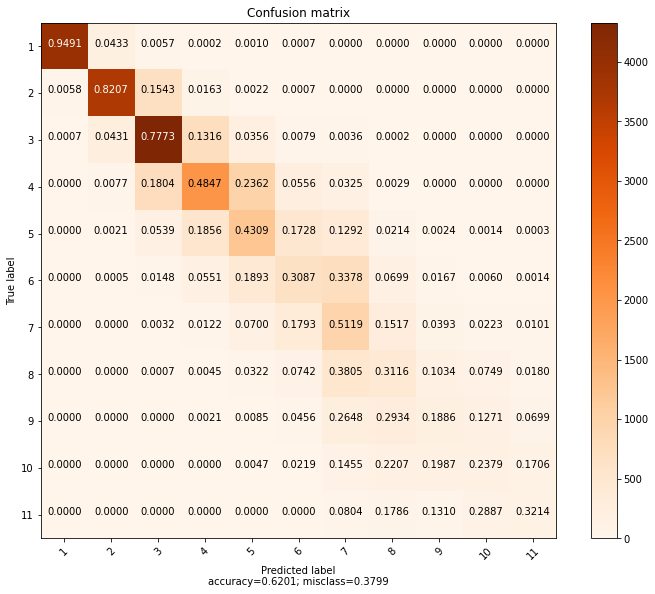

In [ ]:
y_pred_cnn, accuracy_cnn, cm_cnn = predict_model(model, X_test, y_test, "CNN Model")
del y_pred_cnn

<h3>LeNet</h3>

In [ ]:
if 'model' in locals(): del model

inputs=Input(shape = (height, width,1), name = "Input")
conv_1 = Conv2D(filters = 30,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                input_shape = (height, width,1),       # Dimensions de l'image en entrée
                activation = 'relu')             # Fonction d'activation
max_pool_1 = MaxPooling2D(pool_size = (2, 2))
dropout1 = Dropout(rate = 0.2)
conv_2 = Conv2D(filters = 50,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')
max_pool_2 = MaxPooling2D(pool_size = (2, 2))
dropout2 = Dropout(rate = 0.2)
flatten = Flatten()
dense_1 = Dense(units = 128,
                activation = 'relu')
dense_2 = Dense(units = num_classes,
                activation = 'softmax')
x=conv_1(inputs)
x=max_pool_1(x)
x=dropout1(x)
x=conv_2(x)
x=max_pool_2(x)
x=dropout2(x)
x=flatten(x)
x=dense_1(x)
outputs=dense_2(x)

model = Model(inputs = inputs, outputs = outputs, name="LeNet")
model.summary()

Model: "LeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 124, 30)       780       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 62, 30)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 14, 62, 30)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 60, 50)        13550     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 30, 50)        0         
 g2D)                                                        

Epoch 1/16
834/834 [==============================] - 13s 15ms/step - loss: 1.1732 - accuracy: 0.5436 - val_loss: 0.9356 - val_accuracy: 0.6263
Epoch 2/16
834/834 [==============================] - 13s 15ms/step - loss: 0.8784 - accuracy: 0.6436 - val_loss: 0.8763 - val_accuracy: 0.6345
Epoch 3/16
834/834 [==============================] - 12s 15ms/step - loss: 0.7899 - accuracy: 0.6775 - val_loss: 0.7980 - val_accuracy: 0.6744
Epoch 4/16
834/834 [==============================] - 14s 16ms/step - loss: 0.7390 - accuracy: 0.6983 - val_loss: 0.7567 - val_accuracy: 0.6820
Epoch 5/16
834/834 [==============================] - 14s 16ms/step - loss: 0.6810 - accuracy: 0.7234 - val_loss: 0.7144 - val_accuracy: 0.7079
Epoch 6/16
834/834 [==============================] - 13s 15ms/step - loss: 0.6375 - accuracy: 0.7434 - val_loss: 0.7102 - val_accuracy: 0.7095
Epoch 7/16
834/834 [==============================] - 13s 15ms/step - loss: 0.6034 - accuracy: 0.7566 - val_loss: 0.7132 - val_accuracy:

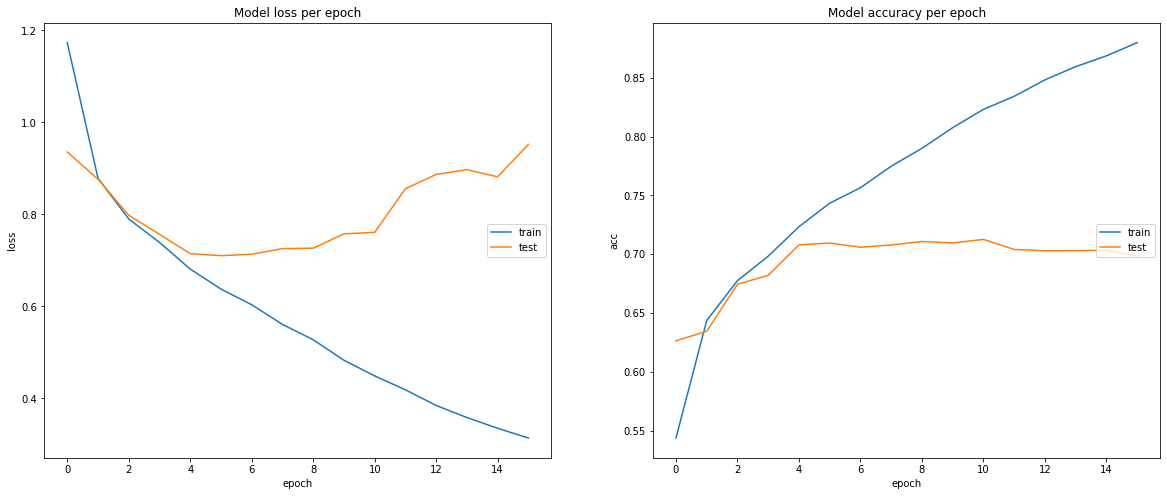

In [ ]:
training_history_lenet = train_model(model, X_train, y_train)




Accuracy model LeNet :  0.6885188553837542


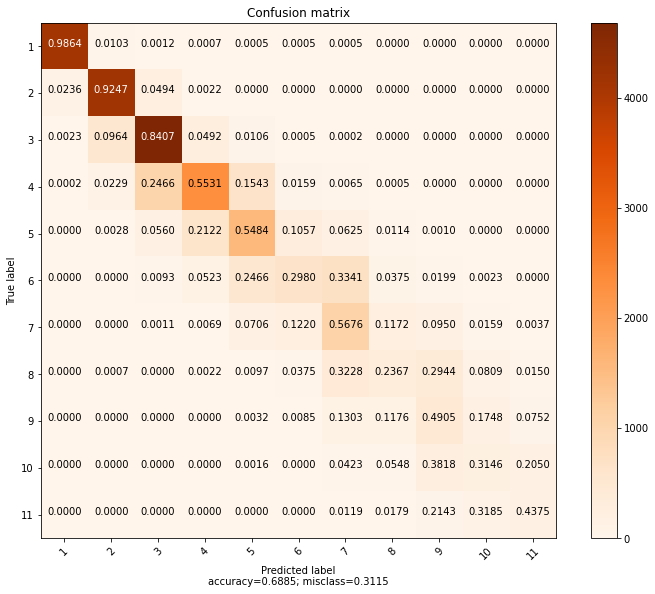

In [ ]:
y_pred_lenet, accuracy_lenet, cm_lenet = predict_model(model, X_test, y_test, 'LeNet')

In [ ]:
print(accuracy_dense)
print(accuracy_cnn)
print(accuracy_lenet)


0.4991254460225285
0.6201287343454838
0.6885188553837542
0.6563352690128035
